# Naive Bayes Models for Sentiment Analysis

Using the sentiment labelled sentences dataset ('From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015), I will be testing the accuracy of a Naive Bayes classifier on the imdb reviews and looking at the transferability to amazon reviews.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns
%matplotlib inline

In [2]:
# Import training dataset
df = pd.read_csv('imdb_labelled.txt', names=['sentence', 'score'], delimiter='\t')
df.head()

,sentence,score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [3]:
# Create list of words to use as features for sentiment analysis
good_words = ['hilarious', 'entertain', 'heart-warming', 'touching', 'good', 'great', 'excellent', 'amazing', 'incredible',
              'best', 'funny', 'funniest', 'perfect', 'impress', 'enjoy', 'solid', 'favorite', 'favourite', 'powerful',
             'moving', 'nice', 'joy', 'vibrant', 'ground-breaking', 'thought-provoking', 'exceptional', 'masterpiece', 'creative',
             'interesting', 'fantastic', 'pleasing', 'pleasant', 'thoughtful', 'wonderful', 'dynamic', 'triumph', 'beautiful',
             'stunning', 'marvelous', 'brilliant', 'original', 'breathtaking']

# added leading spaces for words that could be contained within other words, dropped suffixes to catch extras * wast: waste, wasteful, wasting
bad_words = ['bad', 'horrible', 'horrendous', 'terrible', 'boring', 'bored', 'stupid', 'dumb', 'pathetic', 'flat', 'slow',
            'worst', 'lackluster', 'awful', 'contrived', 'derivative', 'mindless', 'shame', 'unlikeable', 'predictable', 'cring',
            'hate', 'detest', 'loathe', 'wrong', ' lack', 'dull', 'lost', 'sleep', 'slept', 'mediocre', ' wast', ' lose', 'confus',
            'horrid', 'weak', 'disappoint', 'poor', 'trash', ' crap', 'garbage', 'cliche', 'rotten']

words = good_words
words.extend(bad_words)
len(words)

85

In [4]:
# Encode word vector features
for word in words:
    df[str(word)] = df['sentence'].str.contains(word, case=False)
df.head()

,sentence,score,hilarious,entertain,heart-warming,touching,good,great,excellent,amazing,...,confus,horrid,weak,disappoint,poor,trash,crap,garbage,cliche,rotten
0,"A very, very, very slow-moving, aimless movie ...",0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Not sure who was more lost - the flat characte...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Attempting artiness with black & white and cle...,0,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
3,Very little music or anything to speak of.,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,The best scene in the movie was when Gerardo i...,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


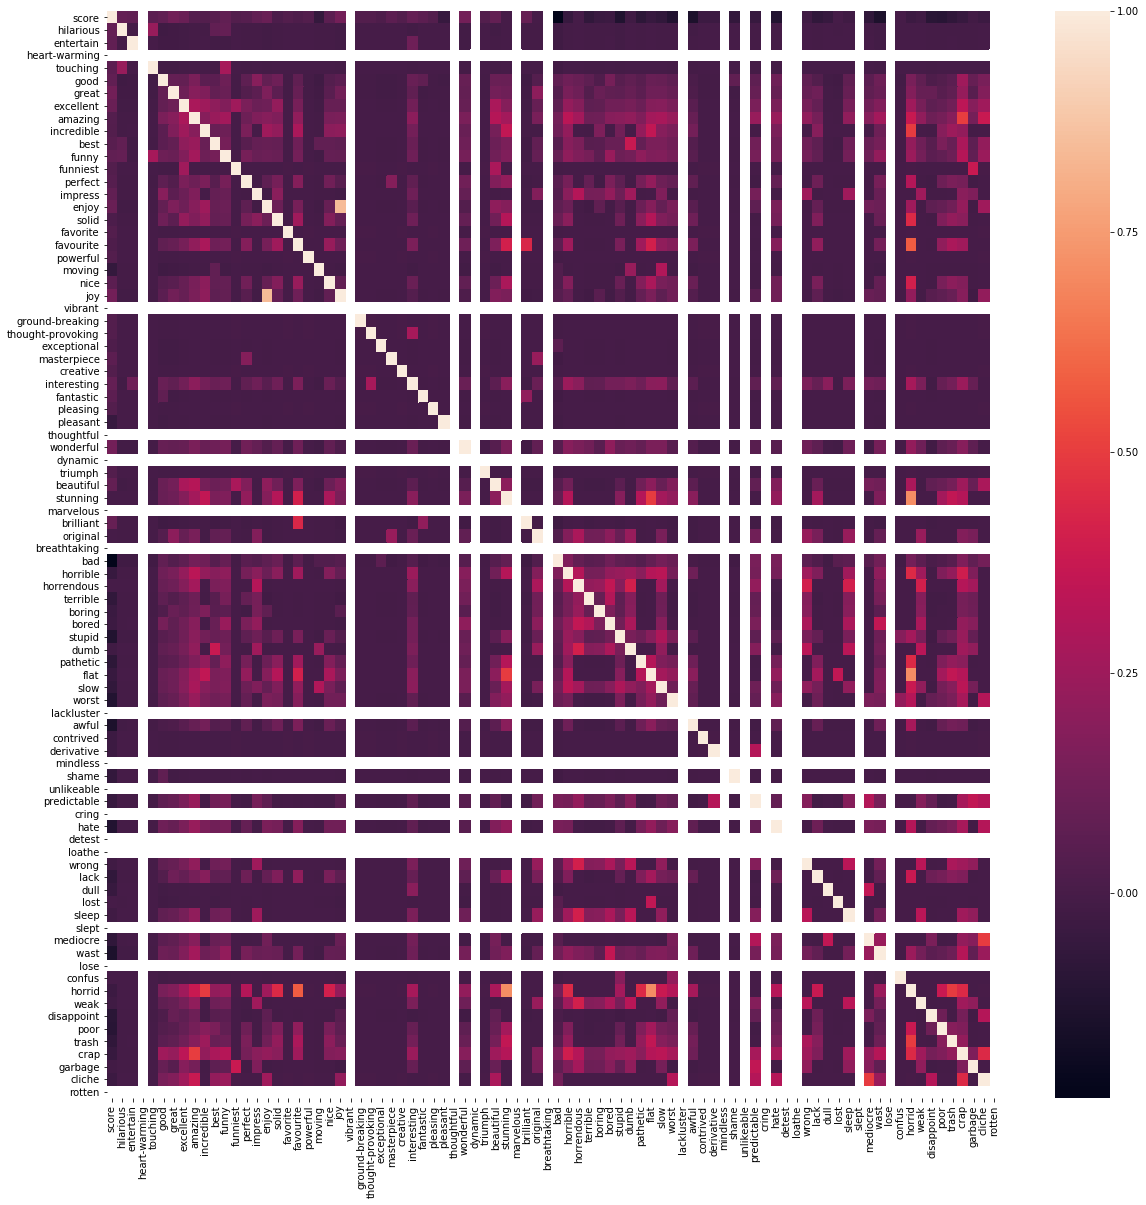

In [5]:
# Check for correlation because of the assumption of independence in Naive Bayes
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())
plt.show()

In [6]:
# Model the data with a Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
data = df[words]
target = df['score']

bnb.fit(data, target)

prediction = bnb.predict(data)

print('Wrong: {} / {}'.format((target != prediction).sum(), len(df)))

Wrong: 209 / 748


In [7]:
# Import the test data
amazon_df = pd.read_csv('amazon_cells_labelled.txt', names = ['sentence', 'score'], delimiter='\t')
amazon_df.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [8]:
# Encode word vector features
for word in words:
    amazon_df[str(word)] = amazon_df['sentence'].str.contains(word, case=False)

In [9]:
# Check the ability of the model to transfer to other data sets
a_data = amazon_df[words]
a_target = amazon_df['score']
a_pred = bnb.predict(a_data)

print('Wrong: {} / {}'.format((a_target != a_pred).sum(), len(amazon_df)))

Wrong: 381 / 1000


## Features and Analysis

I created two lists of keywords after browsing some reviews on the site Rotten Tomatoes. Some of the words were fairly specific to movies or creative works, so I wasn't sure how well they would transfer to Amazon reviews. The accuracy only dropped by 10% though. 

### Shortcomings

The assumption that all features are independent of one another could lead to false positives and false negatives. No context around the keywords means that the classifier misses words that negate the keyword. "This product is not good!" would be classified as a positive review, though the preceding words means it is the opposite of good. There are probably other keywords syntactic markers of sentiment I could have added to boost the performance of the model, but it did relatively well with little work and no context.

## Evaluating Classifier Performance

Now that we have a classifier up and running, it is worth evaluating more critically how it is doing and to determine how we can improve performance.

In [10]:
# Cross-validation and type I, type II errors
from sklearn.metrics import confusion_matrix
import math

cv = 8
n = math.ceil(len(target)/cv)
for i in range(cv):
    indices = np.random.randint(len(target), size=n).tolist()
    bnb.fit(data.iloc[indices], target.iloc[indices])
    cm = confusion_matrix(target.iloc[indices], prediction[indices])
    print('CV Set {} Type I Error: {:2f} Type II Error: {:2f}'.format(i+1, 
                                                               (cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))


CV Set 1 Type I Error: 0.018868 Type II Error: 0.414634
CV Set 2 Type I Error: 0.023256 Type II Error: 0.529412
CV Set 3 Type I Error: 0.039216 Type II Error: 0.558140
CV Set 4 Type I Error: 0.020408 Type II Error: 0.422222
CV Set 5 Type I Error: 0.035088 Type II Error: 0.621622
CV Set 6 Type I Error: 0.000000 Type II Error: 0.600000
CV Set 7 Type I Error: 0.000000 Type II Error: 0.541667
CV Set 8 Type I Error: 0.069767 Type II Error: 0.568627


In [11]:
# Type I and Type II errors on Amazon set
cm = confusion_matrix(a_target, a_pred)
print('Amazon Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))


Amazon Set Type I Error: 0.010000 Type II Error: 0.752000


## Future Iterations

It looks like the model above doesn't seem to be overfitting, but it does have an outsized type II : type I error ratio. For future iterations, I am going to remove words from my feature set that were not found in the data. I am also going to try just the positive words and just the negative words to see if focusing on one sentiment increases predictions. Finally, I would like to try using counts of the words instead of just a boolean response to the word's presence.

In [12]:
# Remove words that were not found in the data from the features
not_there = ['lose', 'cring', 'lackluster', 'slept', 'detest', 'loathe', 'unlikeable', 'mindless',
          'breathtaking', 'marvelous', 'thoughful', 'dynamic', 'vibrant', 'heart-warming']
words = [word for word in words if word not in not_there]
good_words = [word for word in good_words if word  not in not_there]
bad_words = [word for word in bad_words if word not in not_there]

In [13]:
# Model the data on just the positive words
bnba = BernoulliNB()
data = df[good_words]
target = df['score']

bnba.fit(data, target)

prediction = bnba.predict(data)

cm = confusion_matrix(target, prediction)
print('IMDB Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))
# Test the model on the Amazon data
a_data = amazon_df[good_words]
a_target = amazon_df['score']
a_pred = bnba.predict(a_data)

cm = confusion_matrix(a_target, a_pred)
print('Amazon Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))

IMDB Set Type I Error: 0.028497 Type II Error: 0.546961
Amazon Set Type I Error: 0.010000 Type II Error: 0.752000


### Evaluating Positive Sentiment Model
The model using on the words that convey only positive sentiment did not make imporvement or perform worse than the original model.

In [14]:
# Model the data just on the negative words
bnbb = BernoulliNB()
data = df[bad_words]
target = df['score']

bnbb.fit(data, target)

prediction = bnbb.predict(data)

cm = confusion_matrix(target, prediction)
print('IMDB Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))
# Test the model on the Amazon data
a_data = amazon_df[bad_words]
a_target = amazon_df['score']
a_pred = bnbb.predict(a_data)

cm = confusion_matrix(a_target, a_pred)
print('Amazon Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))

IMDB Set Type I Error: 0.028497 Type II Error: 0.574586
Amazon Set Type I Error: 0.006000 Type II Error: 0.770000


### Evaluating Negative Sentiment Model
The model using on the words that convey only negative sentiment performed worse than the original model.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# Create counts for each of the words in the data, then model the data
count_vect = CountVectorizer()
X = count_vect.fit_transform(df.sentence)

mnb = MultinomialNB()

mnb.fit(X, target)

pred = mnb.predict(X)
cm = confusion_matrix(target, pred)
print('IMDB Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))

# Test the model on the Amazon data
a_data = count_vect.transform(amazon_df.sentence)
a_target = amazon_df['score']
a_pred = mnb.predict(a_data)

cm = confusion_matrix(a_target, a_pred)
print('Amazon Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))

IMDB Set Type I Error: 0.041451 Type II Error: 0.022099
Amazon Set Type I Error: 0.358000 Type II Error: 0.258000


### Evaluating the Count Vectorized Model
This model improved performance markedly in all areas except for type I error on the training set, which was already quite low.

In [16]:
# Model the data based on counts for every word and two-word pair
c_vec = CountVectorizer(ngram_range=(1,2))
dat = c_vec.fit_transform(df.sentence)

mnba = MultinomialNB()

mnba.fit(dat, target)

pred1 = mnba.predict(dat)
cm = confusion_matrix(target, pred1)
print('IMDB Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))
# Test the model on the Amazon data
a_data = c_vec.transform(amazon_df.sentence)
a_target = amazon_df['score']
a_pred = mnba.predict(a_data)

cm = confusion_matrix(a_target, a_pred)
print('Amazon Set Type I Error: {:2f} Type II Error: {:2f}'.format((cm[1][0]/sum(cm[1])),
                                                               (cm[0][1]/sum(cm[0]))))

IMDB Set Type I Error: 0.005181 Type II Error: 0.000000
Amazon Set Type I Error: 0.378000 Type II Error: 0.256000


### Evaluating the 1,2 n-grams Count Vectorized Model
This model is probably beginning to overfit. The type II error on the training data is reduced to 0 and the type o I error is negligible. Meanwhile the error on the test set crept up marginally. I predict that including any higher order n-grams would increase the overfitting of the model. One way to reduce the overfitting would be to cross-validate with randomly selected samples from the training set.

## Do any of the models overfit?
Yes. I believe the last model overfits on the data because it is a small dataset and the model is learning on every word and two-word pair. I believe this could be avoided with cross-validation, dropout, skip-grams, and/or a larger dataset.

## Which models seem to perform best? Why?
The model with the count vectorizer seems to perform best. This is likely because it takes all the words into account in the dataset and the frequency with which they occur. The model looking for positive and negative sentiment words did not have a frequency feature.

## Which features seemed to be most impactful to performance?
Positive words seemed to marginally outperform negative words as features in the boolean models. Having counts of the frequency at which words occurred drastically improved the performance and the transferability of the models, though.